In [ ]:
!pip install mne
!pip install pyriemann
!pip install sklearn
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 34.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 KB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyriemann: filename=pyriemann-0.4-py2.py3-none-any.whl size=105117 sha256=84154dd584451099cab1fadd02b11248e8f5f38a929dbb09cdebcfac1ebb64df
  Stored in directory: /root/.cache/pip/wheels/71/43/fd/c7988e1b08c73146d21d92fec794455be9ea16e34a79da656a
Successfully built pyriemann
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=fcce6a303fcd14d7b7dbfe4c72d1927346b1f99fd78c09e50e544e7dc68f1467
  Stored in 

In [ ]:
import torch
from torch import nn


class MultitaskSSVEP(nn.Module):

    def __init__(self, num_channel=10, num_classes=4, signal_length=1000, filters_n1=4, kernel_window_ssvep=59, kernel_window=19, conv_3_dilation=4, conv_4_dilation=4):
        super().__init__()

        filters = [filters_n1, filters_n1 * 2]

        self.conv_1 = Conv2dBlockELU(in_ch=1, out_ch=filters[0], kernel_size=(1, kernel_window_ssvep), w_in=signal_length)
        self.conv_2 = Conv2dBlockELU(in_ch=filters[0], out_ch=filters[0], kernel_size=(num_channel, 1))
        self.conv_3 = Conv2dBlockELU(in_ch=filters[0], out_ch=filters[1], kernel_size=(1, kernel_window), padding=(0,conv_3_dilation-1), dilation=(1,conv_3_dilation), w_in=self.conv_1.w_out)
        self.conv_4 = Conv2dBlockELU(in_ch=filters[1], out_ch=filters[1], kernel_size=(1, kernel_window), padding=(0,conv_4_dilation-1), dilation=(1,conv_4_dilation), w_in=self.conv_3.w_out)
        self.conv_mtl = multitask_block(filters[1]*num_classes, num_classes, kernel_size=(1, self.conv_4.w_out))

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.unsqueeze(x,1)

        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.dropout(x)

        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.dropout(x)

        x = self.conv_mtl(x)
        return x


class Conv2dBlockELU(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, padding=(0,0), dilation=(1,1), groups=1, w_in=None):
        super(Conv2dBlockELU, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, dilation=dilation, groups=groups),
            nn.BatchNorm2d(out_ch),
            nn.ELU(inplace=True)
        )

        if w_in is not None:
            self.w_out = int( ((w_in + 2 * padding[1] - dilation[1] * (kernel_size[1]-1)-1) / 1) + 1 )

    def forward(self, x):
        return self.conv(x)


class multitask_block(nn.Module):
    def __init__(self, in_ch, num_classes, kernel_size):
        super(multitask_block, self).__init__()
        self.num_classes = num_classes
        self.conv_mtl = nn.Conv2d(in_ch, num_classes*2, kernel_size=kernel_size, groups=num_classes)

    def forward(self, x):
        x = torch.cat(self.num_classes*[x], 1)
        x = self.conv_mtl(x)
        x = x.squeeze()
        x = x.view(-1, self.num_classes, 2)
        return x


def test():
    model = MultitaskSSVEP(
        num_channel=11,
        num_classes=40,
        signal_length=250,
    )

    x = torch.randn(2, 11, 250)
    print("Input shape:", x.shape) # torch.Size([2, 11, 250])
    y = model(x)
    print("Output shape:", y.shape) # torch.Size([2, 40, 2])

if __name__ == "__main__":
    test()

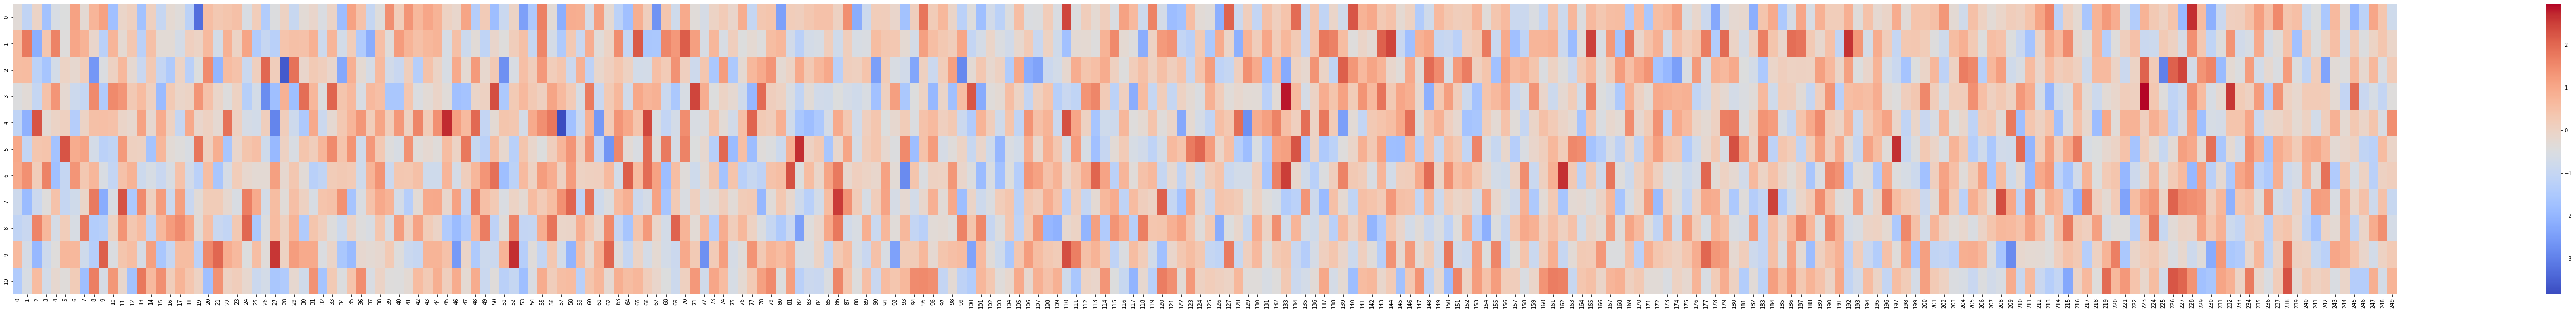

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(100,10))
tensor = torch.randn(2, 11, 250)
sns.heatmap(tensor[0], cmap='coolwarm')
plt.show()

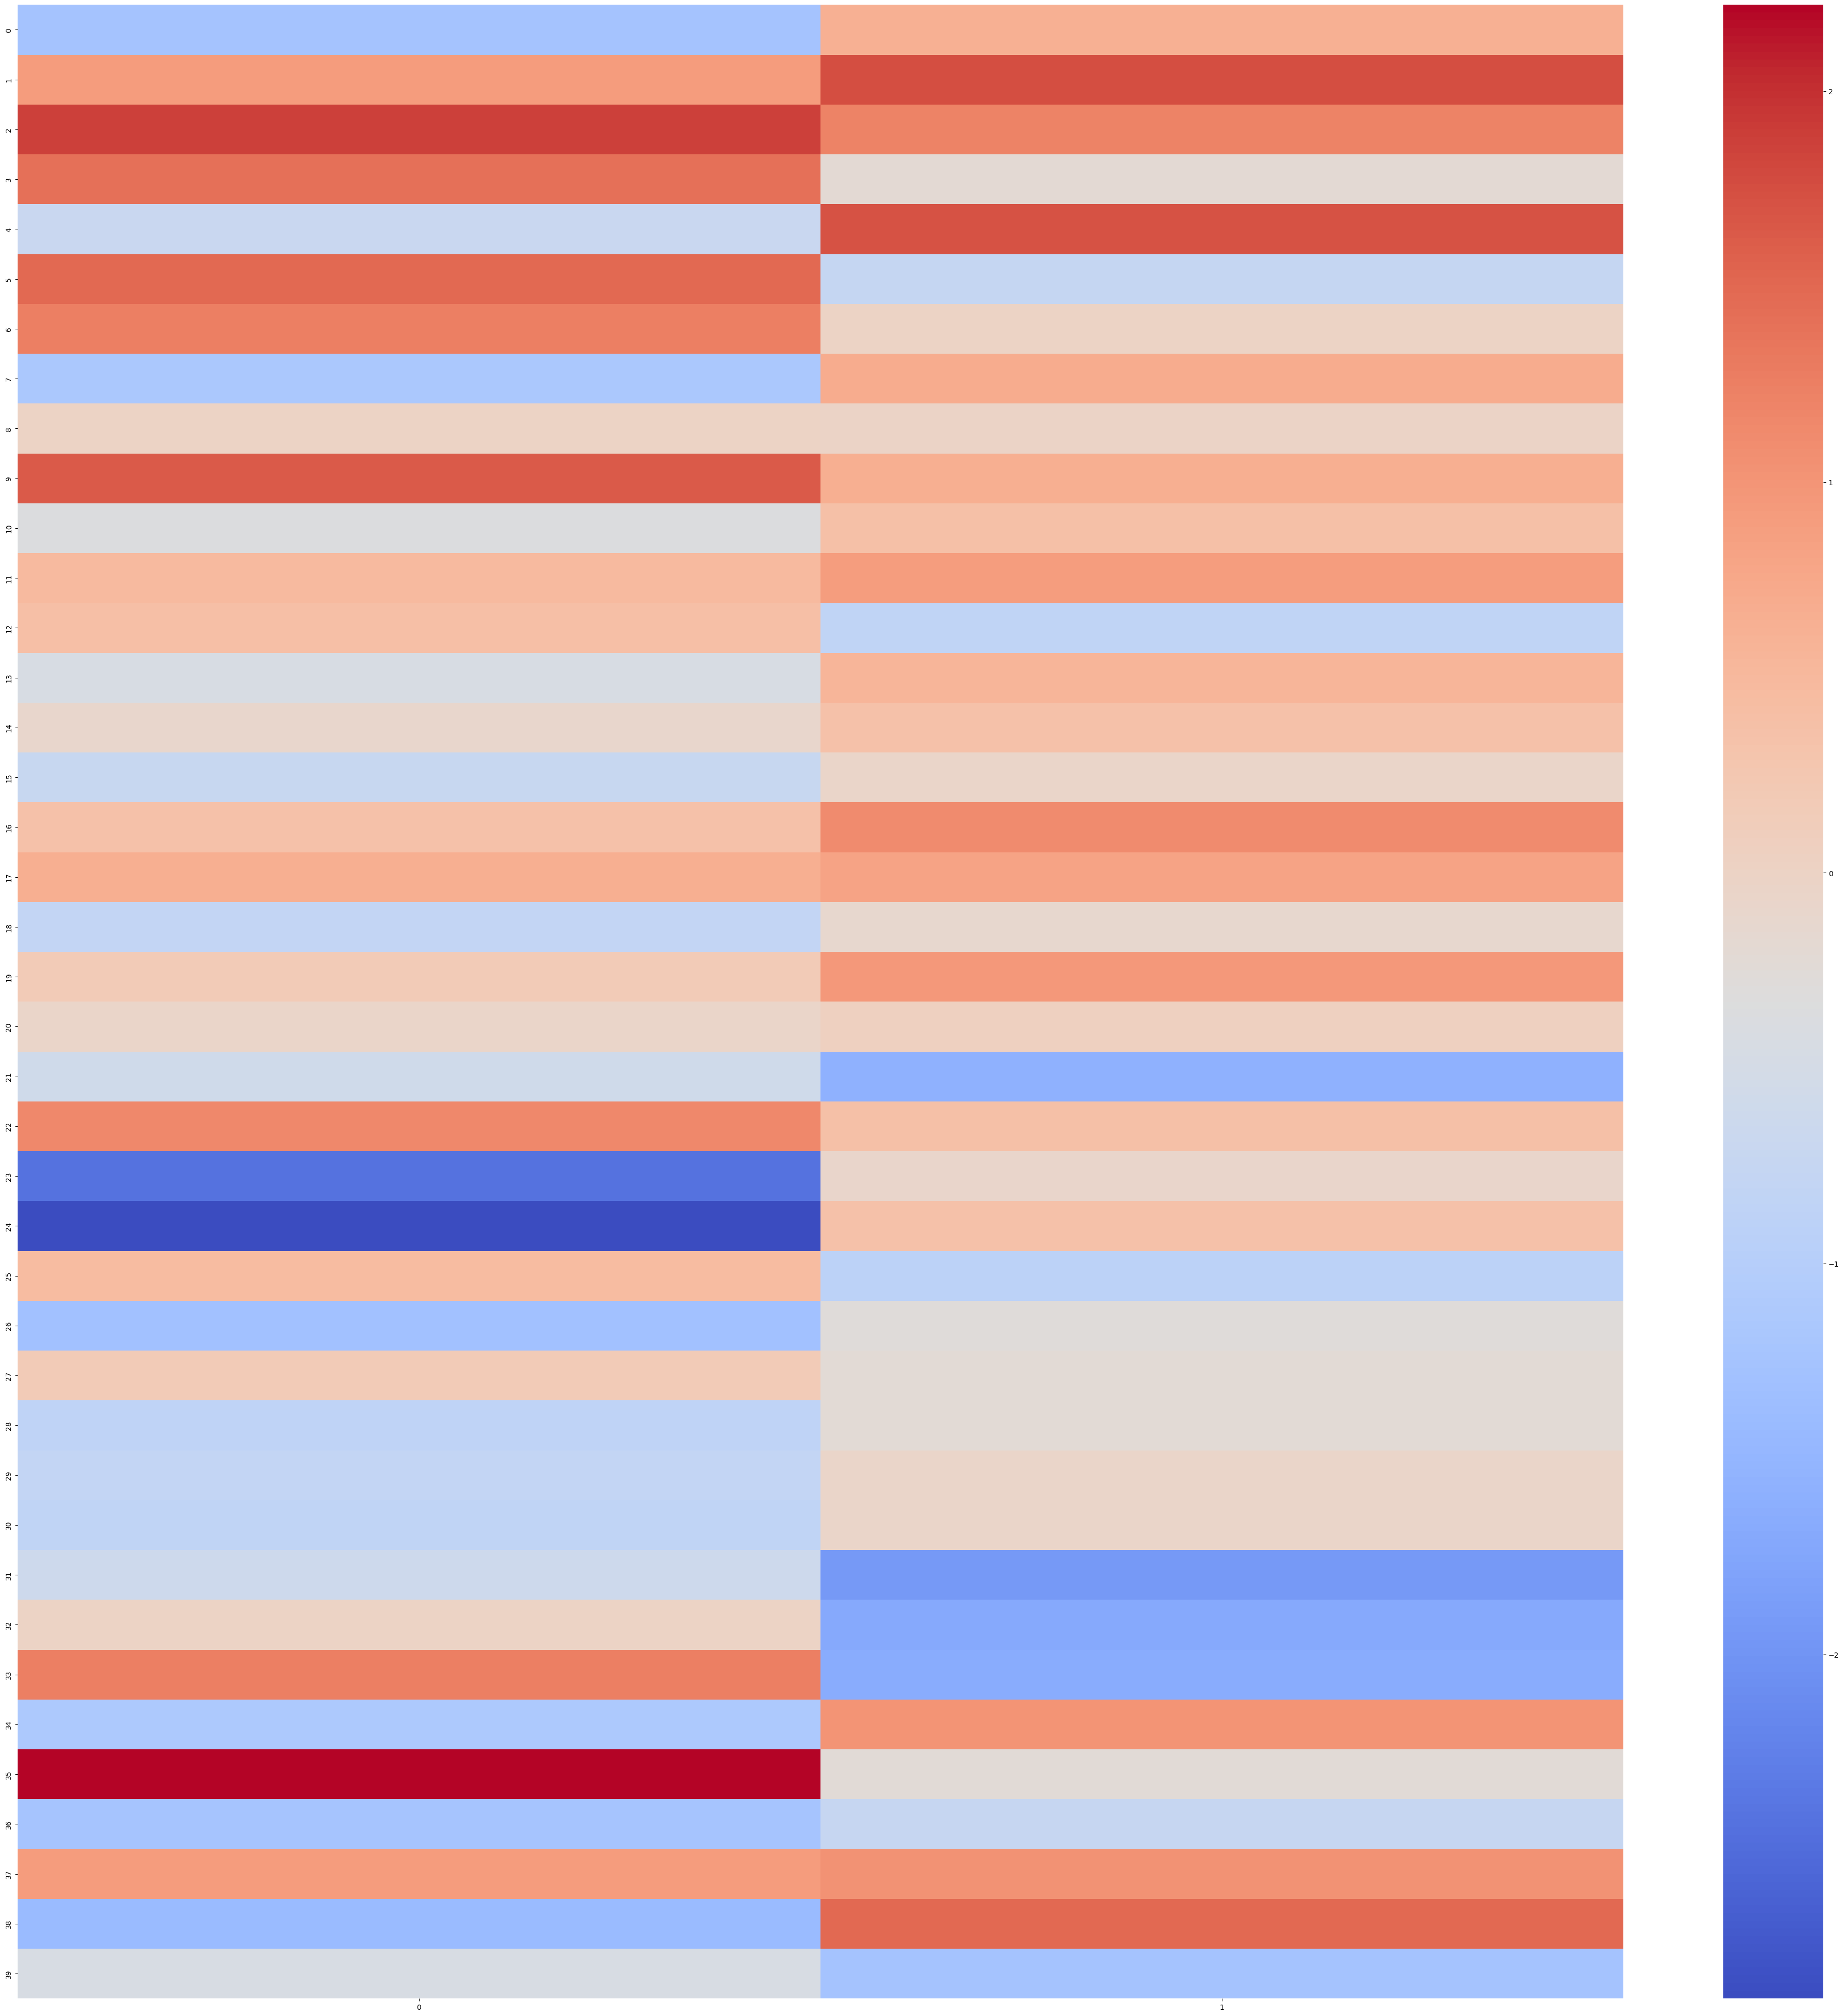

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(50,50))
tensor = torch.randn(2, 40, 2)
sns.heatmap(tensor[0], cmap='coolwarm')
plt.show()

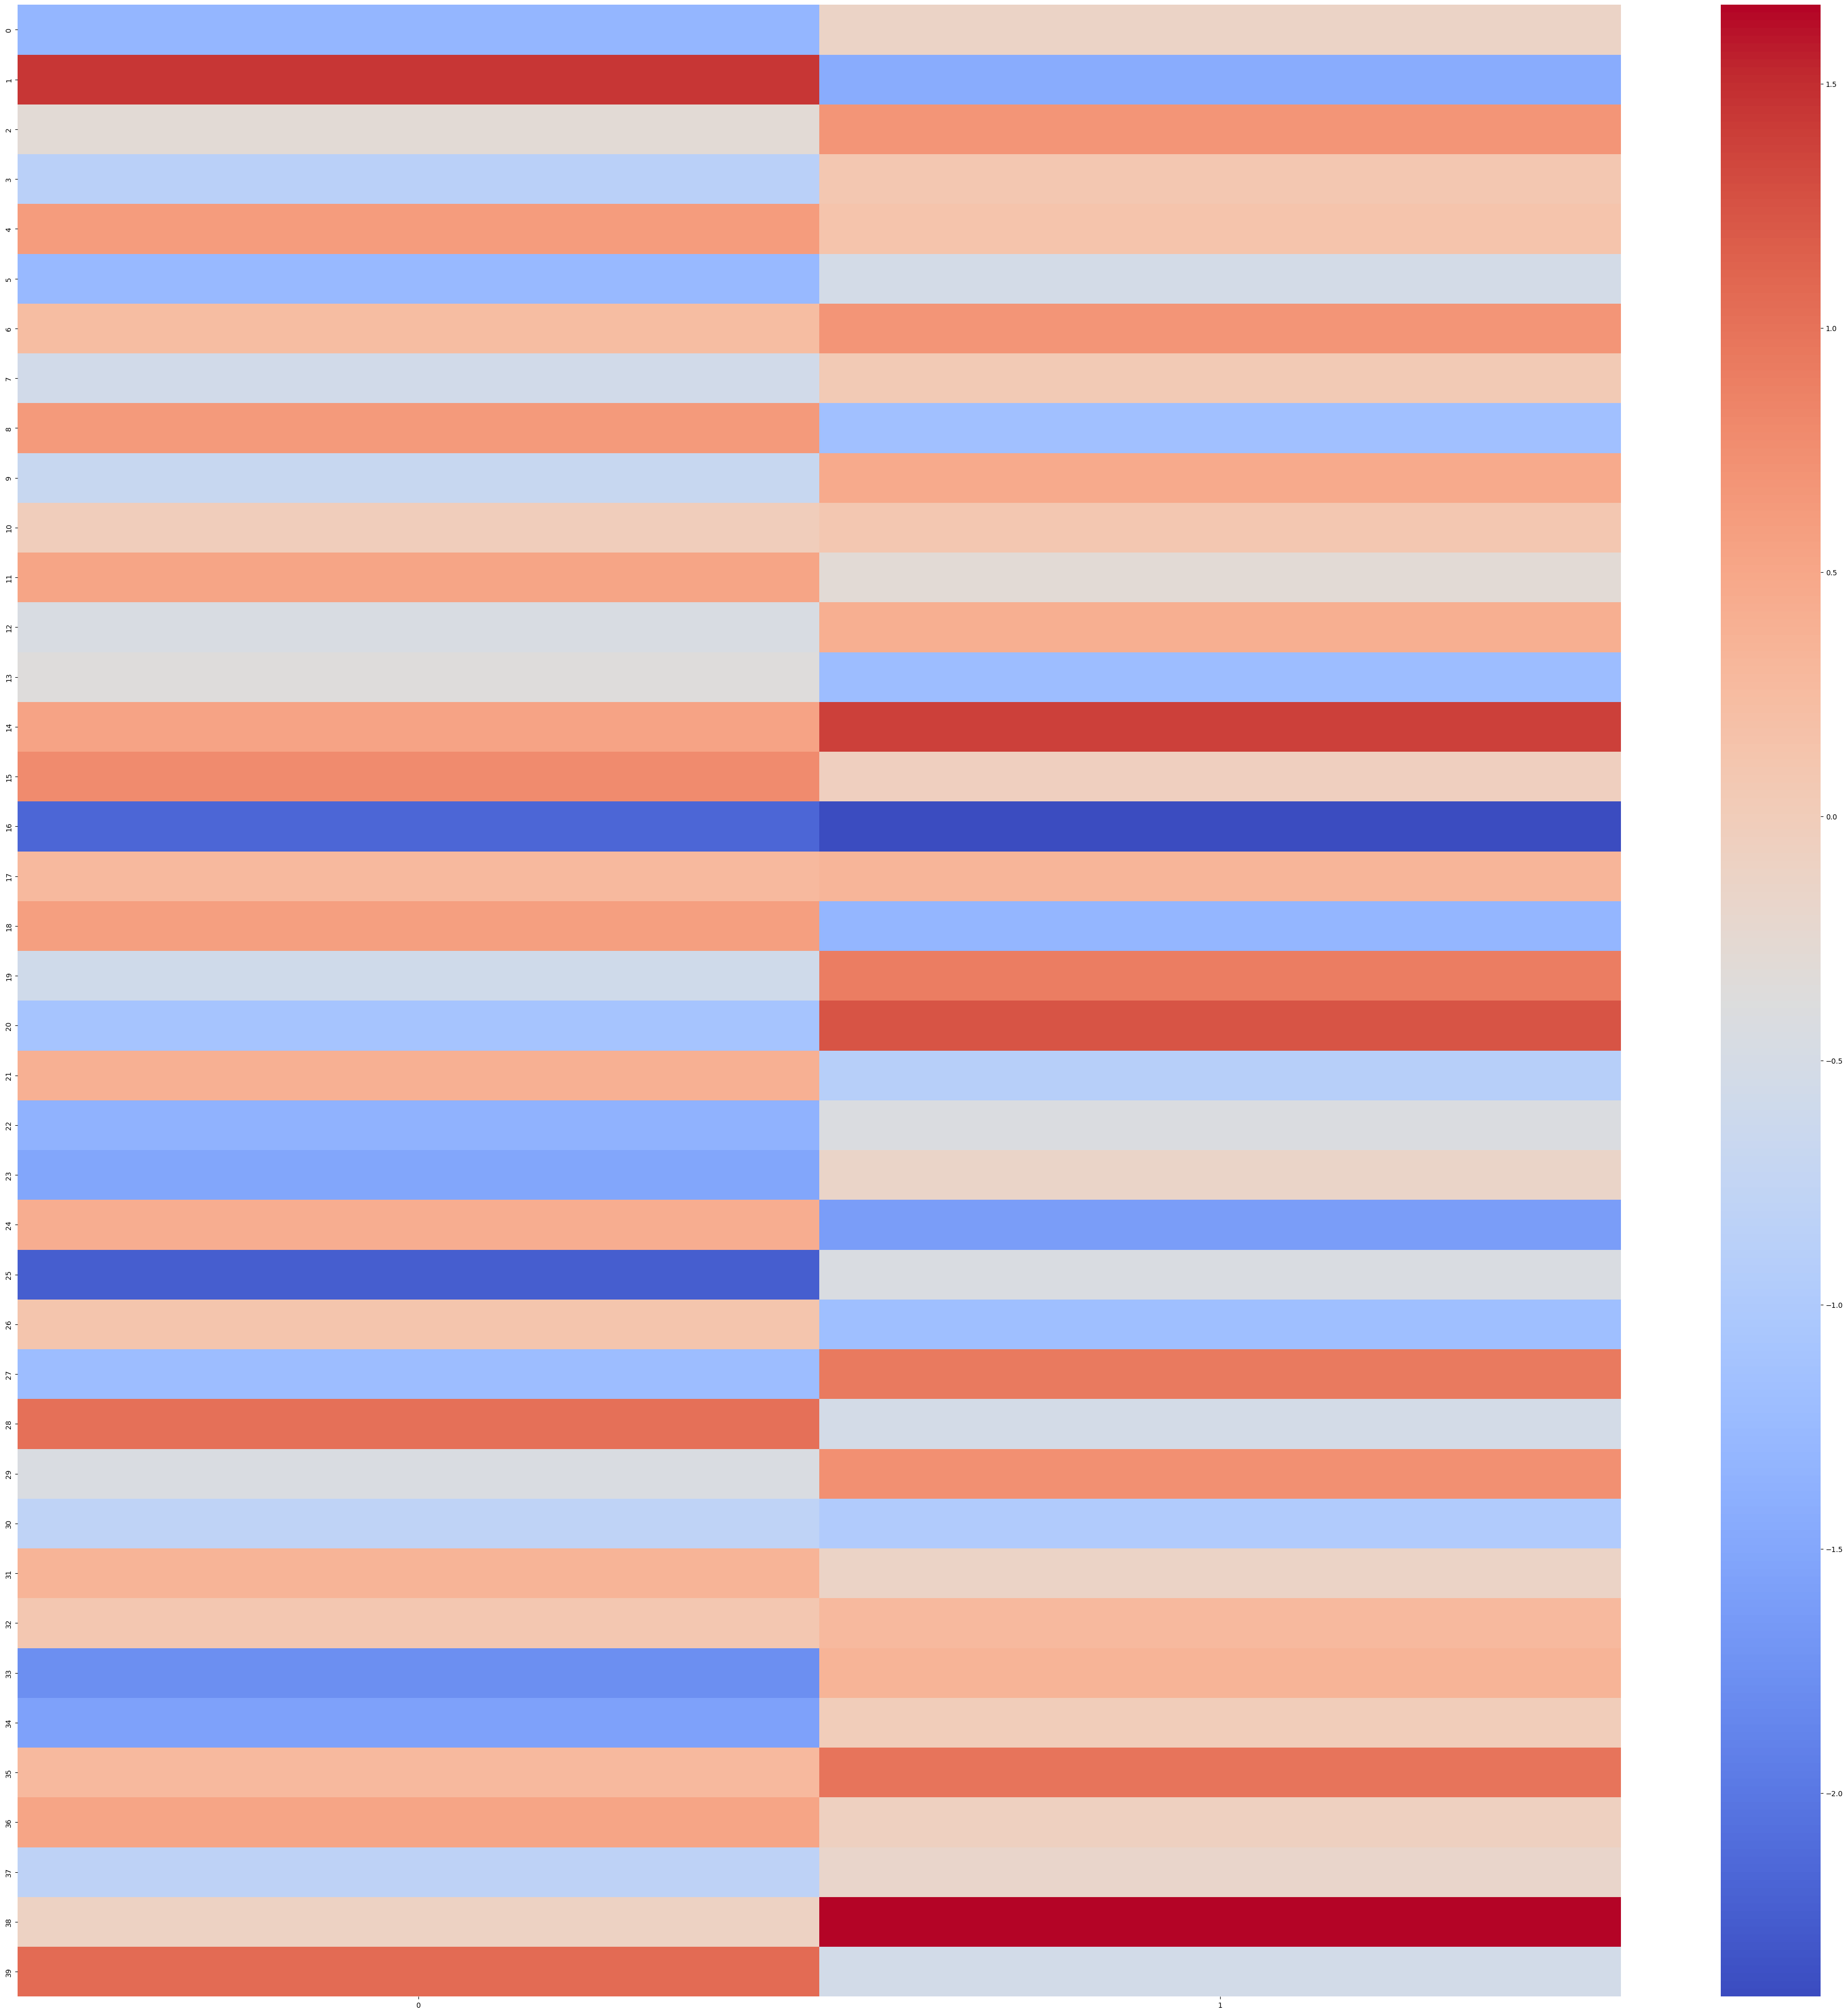

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(50,50))
tensor = torch.randn(2, 40, 2)
sns.heatmap(tensor[0], cmap='coolwarm')
plt.show()



Darker shade values: tensor([-1.4375, -1.0888, -1.8685, -1.4758, -1.0494, -1.1400, -1.5642, -1.9219,
        -2.2315, -1.2776, -1.2327, -1.3987, -1.0581, -1.5967, -1.3479, -1.2779,
        -2.2852, -1.2891, -1.4449, -1.7861, -1.2707, -1.3461, -1.9590, -1.9742,
        -1.4062, -1.4728, -1.4967, -2.2251, -1.5135, -2.4463, -1.3439, -1.3146,
        -1.4054, -1.5431, -2.1581, -1.8289, -1.0890, -1.5658, -1.4302, -1.8864,
        -1.7125, -2.9008, -1.7851, -1.2293, -1.0426, -1.3073, -1.5714, -1.1203,
        -1.2383, -1.3405, -1.0382, -1.7527, -1.1150, -1.0446, -1.3148, -1.0713,
        -1.1128, -1.8947, -1.4664, -1.6387, -1.8844, -1.3676, -1.2670, -1.1483,
        -1.2265, -1.6174, -1.3068, -1.6200, -1.4226, -1.5843, -2.0250, -1.6515,
        -1.4300, -2.0445, -1.8307, -2.5479, -1.2044, -1.3275, -1.4524, -1.1746,
        -2.2228, -1.1078, -1.2819, -1.6872, -1.0100, -1.7098, -2.4048, -1.2902,
        -1.2148, -1.1651, -1.3938, -1.0465, -1.2080, -1.8140, -1.9857, -1.8864,
        -1.0406, -1

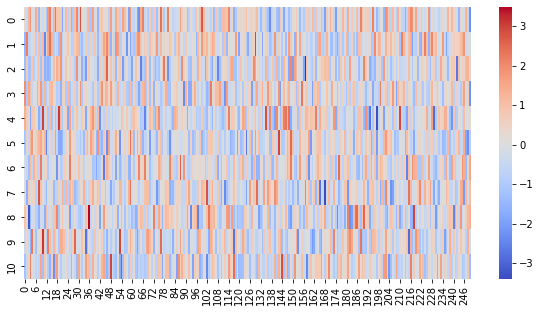

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
tensor = torch.randn(2, 11, 250)
plt.figure(figsize=(10, 5))
sns.heatmap(tensor[0], cmap='coolwarm')
darker_shade_indices = tensor[0] < -1.0
darker_shade_values = tensor[0][darker_shade_indices]
weaker_shade_indices = (-1.0 <= tensor[0]) & (tensor[0] < 0.0)
weaker_shade_values = tensor[0][weaker_shade_indices]
print("Darker shade values:", darker_shade_values)
print("Weaker shade values:", weaker_shade_values)
plt.show()

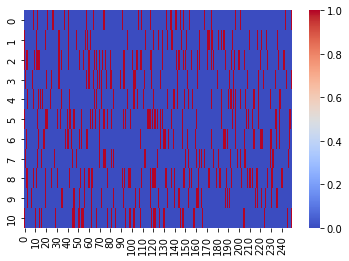

In [ ]:
sns.heatmap(darker_shade_indices, cmap='coolwarm');
plt.show()

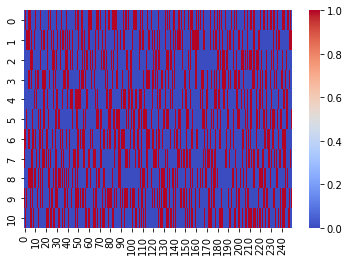

In [ ]:
sns.heatmap(weaker_shade_indices, cmap='coolwarm');
plt.show()

In [ ]:
import numpy as np
arr = np.random.rand(2, 11, 250)
darker_shade = arr[(arr > 0.2) & (arr < 0.4)]
weaker_shade = arr[(arr > 0.4) & (arr < 1.0)]

if np.mean(weaker_shade) > np.mean(darker_shade):
    print("Patient is affected by Glaucoma")
    print(np.mean(weaker_shade))
    print(np.mean(darker_shade))
else:
    print("Normal")

Patient is affected by Glaucoma
0.6946931944577566
0.3006729547893361
